4/4 Final stats: 100%|██████████| 4/4 [00:42<00:00, 10.53s/it]



Vectorized Monte Carlo ELS Pricing (3 Underlyings)
Number of paths: 100000
Fair Value (MC Estimate): 9915.1649

[Event Statistics]
                Event  Frequency  Probability
0   Redeem at day 176      32646      0.32646
1   Redeem at day 362       9957      0.09957
2   Redeem at day 544       8881      0.08881
3   Redeem at day 726       4151      0.04151
4   Redeem at day 908       4683      0.04683
5  Redeem at day 1091       2640      0.02640
6            Knock-In      10433      0.10433
7       No Redemption      26609      0.26609


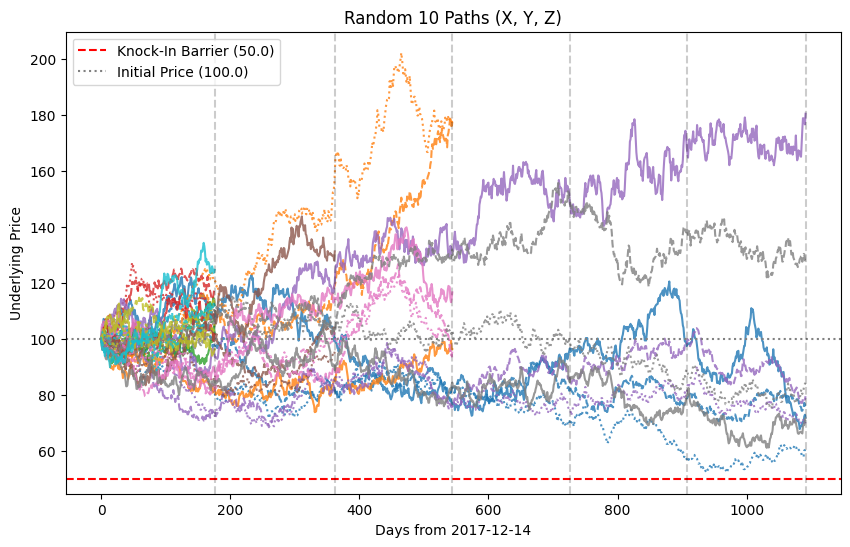

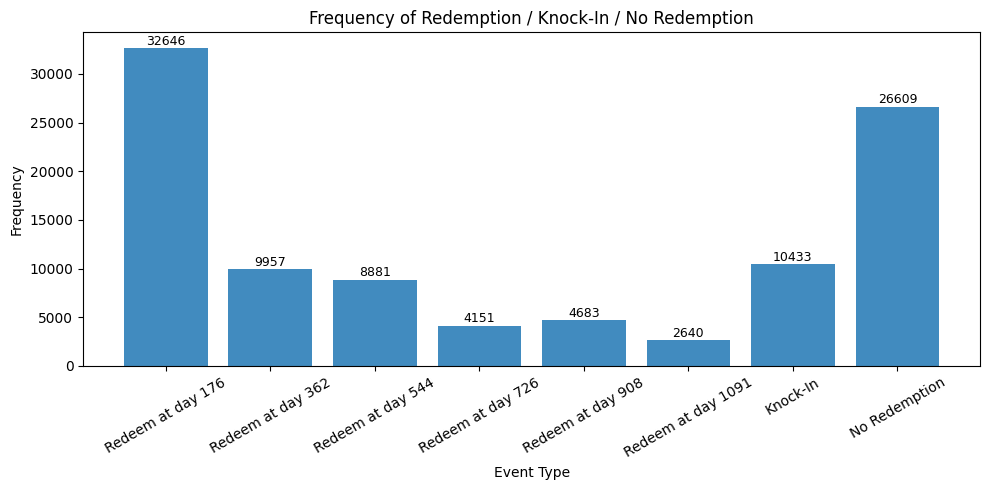

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import date
from tqdm import tqdm

# -----------------------------
# 0) Basic parameters
# -----------------------------
num_paths = 100000        # number of simulated paths
risk_free_rate = 0.0165
vol_x = 0.2662
vol_y = 0.2105
vol_z = 0.2111

# Initial asset prices
init_price_x = 100.0
init_price_y = 100.0
init_price_z = 100.0

# Dates
start_day = date.toordinal(date(2017, 12, 14))
day1 = date.toordinal(date(2018, 6, 8))
day2 = date.toordinal(date(2018, 12, 11))
day3 = date.toordinal(date(2019, 6, 11))
day4 = date.toordinal(date(2019, 12, 10))
day5 = date.toordinal(date(2020, 6, 9))
day_maturity = date.toordinal(date(2020, 12, 9))  # maturity date

check_days = np.array([
    day1 - start_day,
    day2 - start_day,
    day3 - start_day,
    day4 - start_day,
    day5 - start_day,
    day_maturity - start_day
])

days_per_year = 365
total_days = day_maturity - start_day
day_fraction = 1.0 / days_per_year

# Correlation coefficients
rho_xy = 0.279
rho_xz = 0.2895
rho_yz = 0.5256

corr_matrix = np.array([
    [1.0,    rho_xy, rho_xz],
    [rho_xy, 1.0,    rho_yz],
    [rho_xz, rho_yz, 1.0]
])

# Cholesky factorization
cholesky_mat = np.linalg.cholesky(corr_matrix)

# ELS parameters
face_value = 10000.0
strike_ratios = np.array([0.95, 0.95, 0.90, 0.90, 0.85, 0.85])  # early redemption triggers
coupon_rates = np.array([0.048, 0.096, 0.144, 0.192, 0.24, 0.288])
knock_in_barrier = 0.50
dummy_coupon = 0.06
num_check_points = len(strike_ratios)

# Payment upon redemption = principal + coupon
payment_amounts = face_value * (1.0 + coupon_rates)

# Prepare arrays for stats
redemption_counts = np.zeros(num_check_points, dtype=int)
knock_in_count = 0
no_redemption_count = 0

# We'll store log-prices for all paths (for visualization)
log_price_x = np.zeros((num_paths, total_days + 1))
log_price_y = np.zeros((num_paths, total_days + 1))
log_price_z = np.zeros((num_paths, total_days + 1))

# We also need the redemption day index for each path
redemption_day_index = np.zeros(num_paths)

# -----------------------------
# 1) Main simulation with tqdm
# -----------------------------
with tqdm(total=4, desc="Simulation Steps") as pbar:

    # Step 1) Generate correlated random numbers
    pbar.set_description("1/4 Generating correlated randoms")
    np.random.seed(42)
    rand_norm = np.random.normal(0, 1, size=(num_paths, total_days, 3))  # (num_paths x total_days x 3)

    rand_norm_2d = rand_norm.reshape(-1, 3)  # shape = (num_paths * total_days, 3)
    correlated_rand_2d = rand_norm_2d @ cholesky_mat.T
    correlated_rand = correlated_rand_2d.reshape(num_paths, total_days, 3)
    pbar.update(1)

    # Step 2) Build daily log-increments and cumulative sums (log-prices)
    pbar.set_description("2/4 Building asset paths")

    drift_x = (risk_free_rate - 0.5 * vol_x**2) * day_fraction
    drift_y = (risk_free_rate - 0.5 * vol_y**2) * day_fraction
    drift_z = (risk_free_rate - 0.5 * vol_z**2) * day_fraction

    inc_x = drift_x + vol_x * np.sqrt(day_fraction) * correlated_rand[:, :, 0]
    inc_y = drift_y + vol_y * np.sqrt(day_fraction) * correlated_rand[:, :, 1]
    inc_z = drift_z + vol_z * np.sqrt(day_fraction) * correlated_rand[:, :, 2]

    # log_price_x[:, 0] = ln(S0), etc.
    log_price_x[:, 0] = np.log(init_price_x)
    log_price_y[:, 0] = np.log(init_price_y)
    log_price_z[:, 0] = np.log(init_price_z)

    # Build full log-price paths by cumsum of increments
    log_price_x[:, 1:] = log_price_x[:, [0]] + np.cumsum(inc_x, axis=1)
    log_price_y[:, 1:] = log_price_y[:, [0]] + np.cumsum(inc_y, axis=1)
    log_price_z[:, 1:] = log_price_z[:, [0]] + np.cumsum(inc_z, axis=1)

    # Extract prices at check_days
    price_x_check = np.exp(log_price_x[:, check_days])  # shape (num_paths, num_check_points)
    price_y_check = np.exp(log_price_y[:, check_days])
    price_z_check = np.exp(log_price_z[:, check_days])

    # Worst performer ratio at each check day
    wp_check = np.minimum.reduce([
        price_x_check / init_price_x,
        price_y_check / init_price_y,
        price_z_check / init_price_z
    ])  # shape (num_paths, num_check_points)

    pbar.update(1)

    # Step 3) Determine redemption day or go to maturity; calculate payoffs
    pbar.set_description("3/4 Calculating payoffs")

    # redemption_cond[i, j] = True if path i redeems at check point j
    redemption_cond = (wp_check >= strike_ratios)
    # earliest j for each path
    earliest_true_idx = np.argmax(redemption_cond, axis=1)  # returns first True index or 0 if all False
    has_true = np.any(redemption_cond, axis=1)
    final_redemption_idx = np.where(has_true, earliest_true_idx, -1)  # shape (num_paths,)

    payoffs = np.zeros(num_paths)

    # 3-A) For those with early redemption
    early_mask = (final_redemption_idx >= 0)
    early_j = final_redemption_idx[early_mask]
    payoffs[early_mask] = payment_amounts[early_j]
    redemption_day_index[early_mask] = check_days[early_j]

    # 3-B) For those that never redeem early
    late_mask = (final_redemption_idx == -1)
    final_wp = wp_check[:, -1]  # WP at maturity
    no_knock_in_mask = (final_wp > knock_in_barrier)

    payoffs[late_mask & no_knock_in_mask] = face_value * (1.0 + dummy_coupon)
    payoffs[late_mask & ~no_knock_in_mask] = face_value * final_wp[late_mask & ~no_knock_in_mask]

    redemption_day_index[late_mask] = check_days[-1]

    # Discount
    discount_factor = np.exp(-risk_free_rate * (redemption_day_index / days_per_year))
    present_value = payoffs * discount_factor
    price_mc = np.mean(present_value)
    pbar.update(1)

    # Step 4) Gather statistics
    pbar.set_description("4/4 Final stats")

    for j in range(num_check_points):
        redemption_counts[j] = np.sum(final_redemption_idx == j)

    knock_in_mask = late_mask & ~no_knock_in_mask
    knock_in_count = np.sum(knock_in_mask)
    no_redemption_mask = late_mask & no_knock_in_mask
    no_redemption_count = np.sum(no_redemption_mask)

    pbar.update(1)

# --------------------------------
# Print results
# --------------------------------
print(f"\nVectorized Monte Carlo ELS Pricing (3 Underlyings)")
print(f"Number of paths: {num_paths}")
print(f"Fair Value (MC Estimate): {price_mc:.4f}")

# Create stats table
event_freqs = list(redemption_counts) + [knock_in_count, no_redemption_count]
event_labels = [f"Redeem at day {d}" for d in check_days] + ["Knock-In", "No Redemption"]
df_stats = pd.DataFrame({"Event": event_labels, "Frequency": event_freqs})
df_stats["Probability"] = df_stats["Frequency"] / num_paths

print("\n[Event Statistics]")
print(df_stats)

# -----------------------------
# 5) Visualization
# -----------------------------
#
# 5-1) Sample of simulated paths with redemption truncation
#
n_path_plot = 10
plot_indices = np.random.choice(num_paths, n_path_plot, replace=False)
colors = list(mcolors.TABLEAU_COLORS.values())

plt.figure(figsize=(10, 6))
for idx, color in zip(plot_indices, colors[:n_path_plot]):
    # Full path (exponentiate log-price)
    path_x = np.exp(log_price_x[idx, :])  # shape (total_days+1,)
    path_y = np.exp(log_price_y[idx, :])
    path_z = np.exp(log_price_z[idx, :])

    # This path's redemption day index (in "calendar days" from 2017-12-14)
    red_day = int(redemption_day_index[idx])  # e.g. 200, 300, or check_days[-1]
    # If redemption happens at day D, we truncate from (D+1) onward
    if red_day < len(path_x):
        path_x[red_day+1:] = np.nan
        path_y[red_day+1:] = np.nan
        path_z[red_day+1:] = np.nan

    # Plot them with different line styles
    plt.plot(path_x, linestyle='-', alpha=0.8, color=color, label=None)
    plt.plot(path_y, linestyle='--', alpha=0.8, color=color, label=None)
    plt.plot(path_z, linestyle=':', alpha=0.8, color=color, label=None)

# Knock-In Barrier line (for asset X's initial price)
plt.axhline(
    y=init_price_x * knock_in_barrier,
    color='red', linestyle='--',
    label=f"Knock-In Barrier ({init_price_x*knock_in_barrier})"
)

# Initial price line
plt.axhline(
    y=init_price_x,
    color='gray', linestyle=':',
    label=f"Initial Price ({init_price_x})"
)

# Vertical lines for redemption points
for cd in check_days:
    plt.axvline(x=cd, color='black', linestyle='--', alpha=0.2)

plt.title(f"Random {n_path_plot} Paths (X, Y, Z)")
plt.xlabel("Days from 2017-12-14")
plt.ylabel("Underlying Price")
plt.legend(loc='upper left')
plt.show()

# -----------------------------
# 5-2) Frequency histogram - redemption / Knock-In / No Redemption
# -----------------------------
plt.figure(figsize=(10, 5))
bars = plt.bar(df_stats["Event"], df_stats["Frequency"], alpha=0.85)
plt.title("Frequency of Redemption / Knock-In / No Redemption")
plt.xlabel("Event Type")
plt.ylabel("Frequency")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f"{int(height)}",
        ha='center', va='bottom', fontsize=9
    )

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()